# CarRacing - PPO with clipped objective

### Install video rendering dependancies

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get update  > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg  > /dev/null 2>&1

### Importing librairies

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #for error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from Agent import Agent
from Network import Net
import os

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
# Import Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import time
from collections import deque

In [5]:
# Install CarRacing environment in Box2D
!pip install Box2D

### Video Display Functions

In [6]:
# function to enable rendring through video
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Creating and testing the env

In [7]:
env = wrap_env(gym.make("CarRacing-v0"))

In [8]:
# Testing if the Environment and Videos are working correctly
observation = env.reset()
while True:
    env.render()
    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action)         
    if done: 
      break;
env.close()
show_video()

Track generation: 1272..1594 -> 322-tiles track


### Initializing Training Environment

In [9]:
img_stack=4

transition = np.dtype([('s', np.float64, (img_stack, 96, 96)), 
                       ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (img_stack, 96, 96))])
# hyper-params
GAMMA=0.99
EPOCH= 8 
MAX_SIZE = 2000 
BATCH=128 
EPS=0.1
LEARNING_RATE = 0.001 

In [10]:
# Initializing Training Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

seed = 0 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

action_repeat = 10
env = gym.make('CarRacing-v0', verbose=0)
state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)

device:  cuda
env.action_space.shape:  (3,)
reward_threshold 900


### Preprocessing CarRacing Screenshots

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


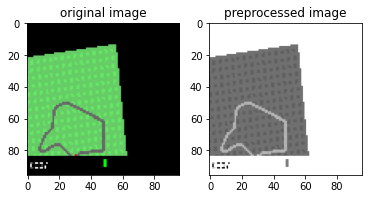

In [11]:
# show what a preprocessed image looks like
frame, _, _, _ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

### Defining some useful functions

In [12]:
class Wrapper():
    """
    Environment wrapper for CarRacing 
    A wrapper function is a subroutine in a software library or a computer program whose main purpose is to call a second subroutine or a system call with little or no additional computation.
    """

    def __init__(self, env):
        self.env = env  

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = env.reset()
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(action_repeat):
            img_rgb, reward, die, _ = env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack
        return np.array(self.stack), total_reward, done, die


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [13]:
#function to load the model chekpoints
def load(agent, directory, filename):
    agent.net.load_state_dict(torch.load(os.path.join(directory,filename)))

In [14]:
#function to run a pretrained agent 
def play(env, agent, n_episodes):
    state = env_wrap.reset()
    
    scores_deque = deque(maxlen=n_episodes)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env_wrap.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action, a_logp = agent.select_action(state)
            env.render()
            next_state, reward, done, die = env_wrap.step( \
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            state = next_state
            score += reward
            
            if done or die:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)

        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))
    return np.mean(scores_deque)

### Testing Agent

In [15]:
#init the agent & the env
agent = Agent(device)
env_wrap = Wrapper(env)

#load model checkpoint
load(agent, '', 'model_weights_latest.pth') 

#use pretrained model on more episodes, you can change the number to reach better results
play(env, agent, n_episodes=5)

Episode 1	Average Score: 28.65,	Score: 28.65 	Time: 00:00:04
Episode 2	Average Score: 59.18,	Score: 89.72 	Time: 00:00:05
Episode 3	Average Score: 48.27,	Score: 26.45 	Time: 00:00:02
Episode 4	Average Score: 39.69,	Score: 13.93 	Time: 00:00:03
Episode 5	Average Score: 37.94,	Score: 30.98 	Time: 00:00:02


37.94377073062618

## Render training results

In [16]:
import os
env_test = Monitor(gym.make("CarRacing-v0"), './video', force=True)
env_test.reset()
env_wrap = Wrapper(env_test)
load(agent, '', 'model_weights_latest.pth')
play(env_test, agent, n_episodes=1)
while True:
    env_test.render()
    action = env_test.action_space.sample() 
    observation, reward, done, info = env_test.step(action)         
    if done: 
      break;
env_test.close()
show_video()

Track generation: 1184..1484 -> 300-tiles track
Episode 1	Average Score: 30.20,	Score: 30.20 	Time: 00:00:02


In [17]:
env.close()